# Распознавание чисел с помощью CRNN

In [1]:
import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import CTCLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms as T
import shared_paths as paths
from word_recognition import dataset_utils, crnn

Будем решать задачу распознавания изображений чисел, сгенерированных с помощью библиотеки [`trdg`](https://pypi.org/project/trdg/). Эти изображения имеют произвольную ширину, зависящую от длины последовательности чисел, и высоту 32 пикселя. Ниже показан пример.

![5456379](images/trdg_digit_example.jpg "Пример изображения")

Загрузим датасет. Будем переводить изображения в 1-канальные и инвертировать цвета, чтобы полезная информация была закодирована как числа > 0.

In [2]:
dataset = dataset_utils.TRDGDataset(
    root='data/trdg/digits',
    transform=T.Compose((
        T.Grayscale(1),
        T.ToTensor(),
        T.functional.invert
    ))
)

Text(0.5, 1.0, 'label = 75')

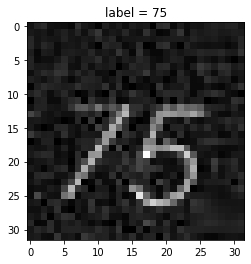

In [3]:
img, seq, seq_len = random.choice(dataset)

plt.imshow(img[0].numpy(), cmap='gray')
plt.title(f'label = {seq}')

Разделим загруженные датасет на тренировочную и валидационную выборки, создадим соответствующие `DataLoader`'ы. Также сгенерируем словарь `vocab` которые позволит переводить символы в токены и обратно. Функция `collate_fn` нужна для того, чтобы избежать проблем, возникающих из-за разных ширин изображений и длин последовательностей чисел.

In [4]:
BATCH_SIZE = 64

train_dataset, val_dataset = random_split(dataset, [9000, 1000])
vocab = dataset_utils.make_char_vocab(train_dataset)
collate_fn = partial(dataset_utils.collate_fn, vocab=vocab)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

Для решения поставленной задачи будем использовать архитектуру CRNN, описанную в работе [An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/abs/1507.05717). В ней набор признаков изображений преобразуется в последовательность, которая обрабатывается с помощью двух BiLSTM, в результате чего на выходе получается набор вероятностных распределений для разных областей изображения.

![CRNN](images/CRNN_architecture.png "архитектура CRNN")

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Архитектура повторяет описанную в статье.

In [6]:
model = crnn.CRNN(output_dim=len(vocab)).to(DEVICE)
model


CRNN(
  (cnn): OriginalCNN(
    (stack): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU()
      (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): 

Функции для тренировки и тестирования.

In [7]:
GRAD_CLIP = 1.0

def train_epoch(model, dataloader, optimizer, loss_fn, device=DEVICE):
    model.train()
    total_loss = 0.0
    num_samples = 0
    for X, y, len_y in dataloader:
        # check batch size
        batch_size = len(X)
        num_samples += batch_size

        # forward pass
        X, y, len_y = X.to(device), y.to(device), len_y.to(device)
        logits = model(X)
        log_probs = F.log_softmax(logits, dim=-1)

        # backpropagation
        len_X = torch.LongTensor([log_probs.size(0)] * batch_size)
        loss = loss_fn(log_probs, y, len_X, len_y)
        optimizer.zero_grad()
        loss.backward()
        if GRAD_CLIP:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        # use weighted sum for calculating avg loss per sample
        total_loss += loss.item() * batch_size

    return total_loss / num_samples


@torch.no_grad()
def validate_epoch(model, dataloader, loss_fn, device=DEVICE):
    model.eval()
    total_loss = 0.0
    num_samples = 0

    for X, y, len_y in dataloader:
        # check batch size
        batch_size = len(X)
        num_samples += batch_size

        # forward pass a
        X, y, len_y = X.to(device), y.to(device), len_y.to(device)
        logits = model(X)
        probs = F.log_softmax(logits, dim=-1)

        # calculate loss
        len_X = torch.LongTensor([probs.size(0)] * batch_size)
        loss = loss_fn(probs, y, len_X, len_y)
        total_loss += loss.item() * batch_size

    return total_loss / num_samples

Обучим модель. В данном случае изображения довольно чёткие, а набор символов невелик, в результате чего модель обучается достаточно быстро.

Epoch 9: train_loss: 1.66e-02, val_loss: 3.20e-02


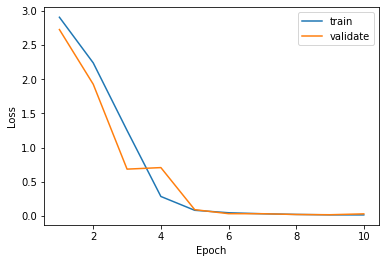

In [8]:
EPOCHS = 10
LR = 1e-4

train_loss = np.zeros(EPOCHS)
val_loss = np.zeros_like(train_loss)
loss_fn = CTCLoss(blank=0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

for i in range(EPOCHS):
    train_loss[i] = train_epoch(model, train_dataloader, optimizer, loss_fn)
    val_loss[i] = validate_epoch(model, val_dataloader, loss_fn)
    print(f'\rEpoch {i}: train_loss: {train_loss[i]:.2e}, val_loss: {val_loss[i]:.2e}',
          end='')
print()

plt.figure()
x = np.arange(1, EPOCHS + 1)
plt.plot(x, train_loss, label='train')
plt.plot(x, val_loss, label='validate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Проверим, как модель распознаёт случайное изображение из валидационной выборки.

Per frame predictions: 8<-><->5<-><->6<-><->1<->1<->9<-><-><->
Actual: 856119


(-0.5, 72.5, 31.5, -0.5)

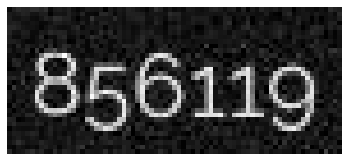

In [9]:
img, y, _ = random.choice(val_dataset)
model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
prediction_tokens = np.argmax(logits, -1)
predictions = dataset_utils.decode(vocab, prediction_tokens)
print(f'Per frame predictions: {predictions}')
print(f'Actual: {y}')
plt.imshow(img[0].numpy(), cmap='gray')
plt.axis('off')